In [1]:
try:
  import google.colab
  print("Running in a colab, all good")
except:
  raise "You need to run this notebook in a Google Colab !"

Running in a colab, all good


## Note before running the repo
In order to run this notebook, you need the datasets of cyclones, in a hierarchy as follows : 
```
data
  |--- ibtracs-gulf of mexico-1998-2015.csv
  |--- ibtracs-japan-1998-2015.csv
```
You can either upload the files manually yo collab, or run the commands below to automatically download the files from our github repo

In [2]:
!mkdir data
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv' -O "data/ibtracs-gulf of mexico-1998-2015.csv"
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv' -O "data/ibtracs-japan-1998-2015.csv"

--2023-01-19 15:05:32--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235033 (230K) [text/plain]
Saving to: ‘data/ibtracs-gulf of mexico-1998-2015.csv’

data/ibtracs-gulf o 100%[===================>] 229.52K  --.-KB/s    in 0.02s   

2023-01-19 15:05:32 (12.5 MB/s) - ‘data/ibtracs-gulf of mexico-1998-2015.csv’ saved [235033/235033]

--2023-01-19 15:05:32--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connec

## Parameters and variables

In [5]:
#Notebook parameters
#zoneAnalysis = "Japan"
zoneAnalysis = "Gulf of Mexico"

In [6]:
#usefull global variables
maxLon, minLon, maxLat, minLat = 0,0,0,0
minYear = 1998
maxYear = 2015

if (zoneAnalysis == "Gulf of Mexico"):
    maxLon = 282
    minLon = 256
    maxLat = 32
    minLat = 18
else:
    maxLon = 145
    minLon = 120
    maxLat = 40
    minLat = 20

## Initialisation & Data loading

In [7]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [37]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings, gc
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


In [9]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [10]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [11]:
params = {"min_lat": minLat, "max_lat": maxLat, "min_lon": minLon, "max_lon": maxLon}

### SST & SSH request to bigquery database

In [12]:
%%bigquery output --project alert-ground-261008 --params $params
SELECT lon, lat, year, month, day, AVG(sst) AS sst, AVG(ssh) AS ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>@min_lon AND lon<@max_lon AND lat>@min_lat AND lat<@max_lat
GROUP BY lon, lat, year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

### IBTRACS data loading

In [23]:
#data loading from zone files
cyclonesData: pd.DataFrame
if (zoneAnalysis == "Japan"):
    cyclonesData = pd.read_csv("data/ibtracs-japan-1998-2015.csv")
else:
    cyclonesData = pd.read_csv("data/ibtracs-gulf of mexico-1998-2015.csv")

#time conversion
cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME)
cyclonesData["NSEC_TIME"] = cyclonesData.NSEC_TIME.astype("int64")

## Data formating & merging for final dataset

In [14]:
output["ISO_TIME"] = pd.to_datetime(output[['year','month','day']])
output["NSEC_TIME"] = output.ISO_TIME.astype("int64")
output.rename(columns={"lon": "LON", "lat": "LAT"}, inplace=True)
output.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME
0,272.875,29.125,2008,1,19,21.00,0.1878,2008-01-19,1200700800000000000
1,265.875,28.125,2001,2,13,19.80,0.0984,2001-02-13,982022400000000000
2,268.375,28.625,2005,4,12,21.15,0.2088,2005-04-12,1113264000000000000
3,271.875,28.875,2007,2,16,20.10,0.1204,2007-02-16,1171584000000000000
4,266.125,28.125,2009,3,22,21.45,0.2050,2009-03-22,1237680000000000000


In [24]:
coordDegreeMultiple = 0.250

cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME.dt.date)
cyclonesData["CYCLONE_PRESENT"] = 1
cyclonesData[["LAT", "LON"]] = (cyclonesData[["LAT", "LON"]] - coordDegreeMultiple/2) / coordDegreeMultiple
cyclonesData[["LAT", "LON"]] = cyclonesData[["LAT", "LON"]].round()
cyclonesData[["LAT", "LON"]] = cyclonesData[["LAT", "LON"]] * coordDegreeMultiple + coordDegreeMultiple/2
cyclonesData.head()

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,CYCLONE_PRESENT
0,25.375,267.625,1998233N25268,25.0,TD,903679200000000000,1998-08-21,1
1,25.375,266.875,1998233N25268,27.0,TD,903690000000000000,1998-08-21,1
2,25.375,266.125,1998233N25268,30.0,TD,903700800000000000,1998-08-21,1
3,25.625,265.875,1998233N25268,35.0,TS,903711600000000000,1998-08-21,1
4,26.125,265.625,1998233N25268,40.0,TS,903722400000000000,1998-08-21,1


In [25]:
finalData = pd.merge(left=output, right=cyclonesData[['LON', 'LAT', "ISO_TIME", "CYCLONE_PRESENT", "SID"]], how="left", on=['LON', 'LAT','ISO_TIME'])
finalData.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT,SID
0,272.875,29.125,2008,1,19,21.00,0.1878,2008-01-19,1200700800000000000,NaN,NaN
1,265.875,28.125,2001,2,13,19.80,0.0984,2001-02-13,982022400000000000,NaN,NaN
2,268.375,28.625,2005,4,12,21.15,0.2088,2005-04-12,1113264000000000000,NaN,NaN
3,271.875,28.875,2007,2,16,20.10,0.1204,2007-02-16,1171584000000000000,NaN,NaN
4,266.125,28.125,2009,3,22,21.45,0.2050,2009-03-22,1237680000000000000,NaN,NaN


In [26]:
print("From all unique cyclones :",cyclonesData["SID"].nunique())
print(finalData["SID"].nunique(), "were matched in the sst/ssh dataset")

From all unique cyclones : 134
111 were matched in the sst/ssh dataset


Here, we found that not all cyclones in the selected area are matched with the uniform and complete data.
The following code shows why :

In [29]:
cyclonePoints = finalData[finalData["SID"].isna() == False][['LAT', 'LON', 'SID', 'ISO_TIME', "sst"]]
cyclonesWithSST = pd.merge(left=cyclonesData, right=cyclonePoints, how="left", on=['LAT', 'LON', 'SID', 'ISO_TIME'])
cyclonesWithSST.head()

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,CYCLONE_PRESENT,sst
0,25.375,267.625,1998233N25268,25.0,TD,903679200000000000,1998-08-21,1,30.30
1,25.375,266.875,1998233N25268,27.0,TD,903690000000000000,1998-08-21,1,30.30
2,25.375,266.125,1998233N25268,30.0,TD,903700800000000000,1998-08-21,1,30.45
3,25.625,265.875,1998233N25268,35.0,TS,903711600000000000,1998-08-21,1,30.30
4,26.125,265.625,1998233N25268,40.0,TS,903722400000000000,1998-08-21,1,30.30


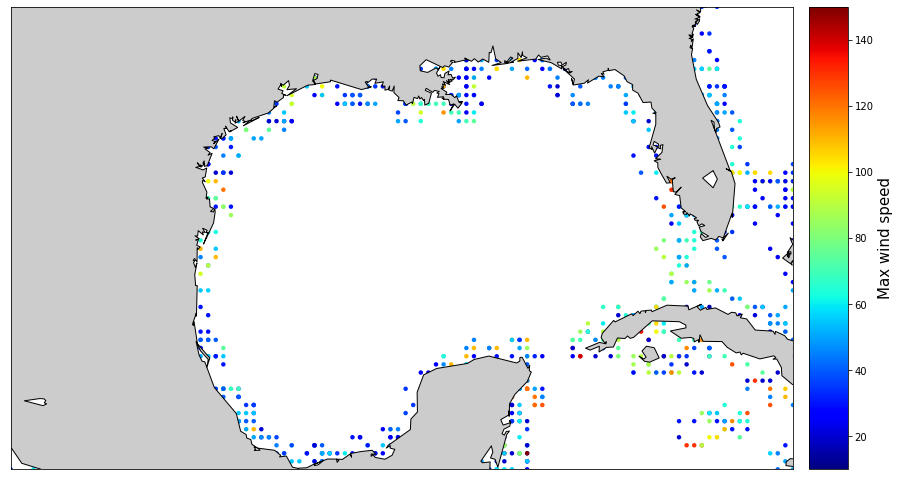

In [31]:
missingData = cyclonesWithSST[cyclonesWithSST["sst"].isna()]
plot_im(missingData.LON, missingData.LAT, missingData.USA_WIND, 20,  "Max wind speed")

As expected, we can't study the cyclone points that are too close to the coast, since we don't have sst data there.

Let's save a new dataset, with all the cyclones points close to the coast removed.

In [33]:
cyclonesWithSST.dropna().drop(columns=["CYCLONE_PRESENT", "sst"]).to_csv("data/ibtracs-"+zoneAnalysis.lower()+"-1998-2015-sst-adapted.csv")

In [ ]:
#free memory
del cyclonePoints
del cyclonesData
del cyclonesWithSST
del missingData

In [38]:
gc.collect()

8246

# Train/test set and model training

In [39]:
#free up memory
del output
gc.collect()

0

In [45]:
finalData["CYCLONE_PRESENT"].fillna(0, inplace=True)
if "SID" in finalData.columns: finalData.drop(columns=["SID"], inplace=True)
finalData.head()

,LON,LAT,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT
835229,267.625,28.875,1998,1,2,17.25,0.0277,1998-01-02,883699200000000000,0.0
694585,272.125,29.375,1998,1,2,18.90,0.0761,1998-01-02,883699200000000000,0.0
974989,266.625,20.625,1998,1,2,24.00,0.1923,1998-01-02,883699200000000000,0.0
7534007,281.375,29.375,1998,1,2,23.40,0.8240,1998-01-02,883699200000000000,0.0
484539,263.625,25.125,1998,1,2,21.75,0.2131,1998-01-02,883699200000000000,0.0


In [42]:
cyclonePtCount = len(finalData[finalData.CYCLONE_PRESENT == 1])
totalDataCount = len(finalData)

print("Points labelled as cyclone present : ", cyclonePtCount, f'({cyclonePtCount/totalDataCount*100:.{2}f}%)')
print("Points labelled as cyclone not present : ",  totalDataCount-cyclonePtCount, f'({(1-cyclonePtCount/totalDataCount)*100:.{2}f}%)')

Points labelled as cyclone present :  1632 (0.01%)
Points labelled as cyclone not present :  14934603 (99.99%)


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score

In [96]:
train_test_ratio = 0.8
positive_ratio = 0.1

data = finalData[finalData["CYCLONE_PRESENT"] == 1] #getting all positive data
data = pd.concat([
    data, 
    finalData.sample(int(len(data)*(1-positive_ratio)/positive_ratio))
]) #mixing with negative data
data.sort_values("NSEC_TIME", inplace=True)

x = data[["LON", "LAT", "year", "month", "day", "sst", "ssh", "NSEC_TIME"]]
y = data["CYCLONE_PRESENT"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio, shuffle=False)

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [97]:
model = RandomForestClassifier()

model.fit(x_train, y_train)

RandomForestClassifier()

In [98]:
y_pred = model.predict(x_test)

print("precision :", precision_score(y_test, y_pred))
print("recall :", recall_score(y_test, y_pred))

precision : 0.23658269441401972
recall : 0.16314199395770393


In [99]:
model.feature_importances_

array([0.12189352, 0.11869174, 0.03551478, 0.17494057, 0.12067904,
       0.13849813, 0.10191794, 0.18786429])